# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

## `Задание 3.5. Трансформеры для Named Entity Recognition`

#### Фамилия, имя:

Дата выдачи: <span style="color:red">__27 марта 23:59__</span>.

Мягкий дедлайн: <span style="color:red">__06 апреля 05:00__</span>.

Стоимость: __10 баллов__ (основная часть заданий)

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

В рамках этого задания вы научитесь:
1. Загружать датасеты и претренированные модели из [Hugging face Hub](https://huggingface.co)
2. Манипулировать текстовыми датасетами с помощью библиотеки [datasets](https://huggingface.co/docs/datasets/index)
3. Запускать и обучать трансформеры с помощью библиотеки [transformers](https://huggingface.co/docs/transformers/index)
4. Промптить большую языковую модель на примере [Qwen2.5-7B-Instruct](https://huggingface.co/Qwen/Qwen2.5-7B-Instruct)
5. Оптимизировать гиперпараметры с помощью библиотеки [optuna](https://optuna.org/)

При выполнении задания вы будете решать стандартную задачу классификации токенов: распознавание именованных сущностей.

Задание состоит из трёх частей:
1. Обработка данных и работа с датасетами из Hugging Face.
2. Практика больших языковых моделей.
3. Дообучение трансформера.

Обратите свое внимание на [официальный гайд](https://huggingface.co/learn/nlp-course/chapter7/2), в котором подробно разбирается задача классификации токенов.

## `Часть 1. Загрузка и предобработка (4 балла)`

### `Подготовка среды Kaggle`

**Хранение ключей**: Kaggle Secrets --- инструмент для безопасного хранения и использования в ноутбуках Kaggle API-ключей, паролей или токенов.

Для добавления нового ключа:
1. Перейдите в Add-ons --> secrets
2. Add secret для добавления нового ключа. Доступ к ключу из ноутбука осуществляется с помощью пакета kaggle_secrets
3. Коллекция ключей общая для всех ноутбуков пользователя на kaggle. Но в каждом ноутбуке необходимо выбрать ключи, которые будут доступны через kaggle_secrets

Ниже находится пример подгрузки ключей для kaggle и wandb.

In [1]:
# from kaggle_secrets import UserSecretsClient
# import os

# api_keys = UserSecretsClient()

# os.system(f"huggingface-cli login --token {api_keys.get_secret('Hug')}")
# os.system(f"wandb login {api_keys.get_secret('wandb')}")

In [2]:
import os
from google.colab import userdata

os.system(f"huggingface-cli login --token {userdata.get('HF_TOKEN')}")
os.system(f"wandb login {userdata.get('Wandb')}")

0

**Установка домашнего каталога**: Если мы хотим контролировать путь, по которому будут загружаться датасеты, чекпоинты моделей и т.д., то стоит задать переменную среды `HF_HOME`. При использовании kaggle перемещение домашнего каталога huggingface в директорию working позволит избежать повторной загрузки при перезапуске ноутбука (не забудьте установить "persistence: files only" в настройках kaggle-ноутбука)

In [3]:
# Optional

os.environ['HF_HOME'] = '/kaggle/working/hf_hub'

### `Подготовка среды Google Colab`

Секреты можно настроить в колабе:

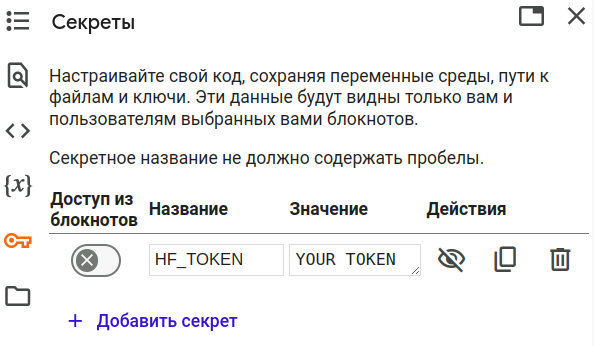

### `Общая подготовка`

In [4]:
# pip offers the --quiet / -q option to silence output

!pip install transformers[torch] sentence-transformers datasets autoawq evaluate seqeval optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

При работе с библиотеками часто бывает важно соблюдение версий. Задание тестировалось на Python 3.12 при версиях библиотек указанных ниже.

In [5]:
!pip freeze > requirements.txt
!cat requirements.txt | grep torch

torch @ https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchsummary==1.5.1
torchvision @ https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl


In [6]:
!cat requirements.txt | grep transformers
!cat requirements.txt | grep datasets
!cat requirements.txt | grep autoawq
!cat requirements.txt | grep evaluate
!cat requirements.txt | grep seqeval
!cat requirements.txt | grep optuna

sentence-transformers==3.4.1
transformers==4.50.3
datasets==3.5.0
tensorflow-datasets==4.9.8
vega-datasets==0.9.0
autoawq==0.2.7.post3
evaluate==0.4.3
seqeval==1.2.2
optuna==4.2.1


In [7]:
import gc
import json
import random
from typing import Any, Union
from pathlib import Path

import numpy as np
import numpy.typing as npt

import torch
import datasets
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TextGenerationPipeline,
    pipeline,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from transformers.trainer_callback import EarlyStoppingCallback

import optuna
import evaluate
import wandb

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.set_detect_anomaly(False)

torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True

In [8]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def print_params_count(model):

    total_params = sum(p.numel() for p in model.parameters())
    total_params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)

    model_name = model.__class__.__name__
    print(f"Информация о числе параметров модели: {model_name}")
    print(f"Всего параметров: \t\t {total_params}")
    print(f"Всего обучаемых параметров: \t {total_params_grad}")
    print()

set_global_seed(42)

На протяжении всего задания вы можете добавлять любой `import`, иногда, это и являются частью задания. При работе с большими библиотеками очень важно уметь читать документацию и использовать гугл для поиска информации.

Для выполнения задания необходимо использование GPU!

In [9]:
if not torch.cuda.is_available():
    print("You need GPU!!!")

### `Загрузка данных (0.25 балла)`

В первую очередь, Hugging Face --- это хаб с датасетами и моделями. Загрузите готовый датасет [отсюда](https://huggingface.co/datasets/voorhs/conll2003-corrupted).

Подсказка: почитайте [туториал](https://huggingface.co/docs/datasets/load_hub).

*Если не получится сразу, то лучше перед следующими попытками перезапустить ноутбук.*

In [10]:
# YOUR CODE IS HERE
dataset = datasets.load_dataset('voorhs/conll2003-corrupted')
dataset

README.md:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/309k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/281k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

**Вопрос**: Какие поля нам доступны? Напечатайте пару примеров из каждого сплита. Попытайтесь догадаться какой смысл имеет каждое поле и опишите в двух словах.

*Подсказка:* почитайте [туториал](https://huggingface.co/docs/datasets/access).

In [11]:
# YOUR CODE IS HERE
dataset['train'].data[0:2]

pyarrow.Table
id: string
tokens: list<item: string>
  child 0, item: string
pos_tags: list<item: int64>
  child 0, item: int64
chunk_tags: list<item: int64>
  child 0, item: int64
ner_tags: list<item: string>
  child 0, item: string
----
id: [["473","8848"]]
tokens: [[["LONDON","1996-08-22"],["WorldCom",",","which","said","it",...,"to","close","at","41-5/16","."]]]
pos_tags: [[[22,11],[21,6,43,38,28,...,35,37,15,11,7]]]
chunk_tags: [[[11,12],[11,0,11,21,11,...,22,22,13,3,0]]]
ner_tags: [[["B-LOC","O"],["B-ORG","O","O","O","O",...,"O","O","O","O","O"]]]

In [12]:
dataset['test'].data[0:2]

pyarrow.Table
id: string
tokens: list<item: string>
  child 0, item: string
pos_tags: list<item: int64>
  child 0, item: int64
chunk_tags: list<item: int64>
  child 0, item: int64
ner_tags: list<item: string>
  child 0, item: string
----
id: [["0","1"]]
tokens: [[["SOCCER","-","JAPAN","GET","LUCKY",...,"CHINA","IN","SURPRISE","DEFEAT","."],["Nadim","Ladki"]]]
pos_tags: [[[21,8,22,37,22,...,22,15,12,21,7],[22,22]]]
chunk_tags: [[[11,0,11,21,11,...,11,13,11,12,0],[11,12]]]
ner_tags: [[["O","O","B-LOC","O","O",...,"B-PER","O","O","O","O"],["B-PER","I-PER"]]]

In [13]:
dataset['validation'].data[0:2]

pyarrow.Table
id: string
tokens: list<item: string>
  child 0, item: string
pos_tags: list<item: int64>
  child 0, item: int64
chunk_tags: list<item: int64>
  child 0, item: int64
ner_tags: list<item: string>
  child 0, item: string
----
id: [["0","1"]]
tokens: [[["CRICKET","-","LEICESTERSHIRE","TAKE","OVER","AT","TOP","AFTER","INNINGS","VICTORY","."],["LONDON","1996-08-30"]]]
pos_tags: [[[22,8,22,22,15,22,22,22,22,21,7],[22,11]]]
chunk_tags: [[[11,0,11,12,13,11,12,12,12,12,0],[11,12]]]
ner_tags: [[["O","O","B-ORG","O","O","O","O","O","O","O","O"],["B-LOC","O"]]]

In [14]:
ner_tags_set = set()

for tags in dataset['train'].data['ner_tags'][1:]:
    ner_tags_set = ner_tags_set | set(tags)
ner_tags_set

{<pyarrow.StringScalar: 'B-LOC'>,
 <pyarrow.StringScalar: 'B-MISC'>,
 <pyarrow.StringScalar: 'B-ORG'>,
 <pyarrow.StringScalar: 'B-PER'>,
 <pyarrow.StringScalar: 'I-LOC'>,
 <pyarrow.StringScalar: 'I-MISC'>,
 <pyarrow.StringScalar: 'I-ORG'>,
 <pyarrow.StringScalar: 'I-PER'>,
 <pyarrow.StringScalar: 'MISSING'>,
 <pyarrow.StringScalar: 'O'>}

---

**Ответ:** доступные поля:
- `id`: уникальный номер объекта в датасете
- `tokens`: текст побитый на токены (почти по словам)
- `pos_tags`:
- `chunk_tags`:
- `ner_tags`: пометки для каждого токена является ли он:
    1. *B-LOC* - начало NE location?
    2. *B-MISC* - начало NE ?
    3. *B-ORG* - начало NE organization?
    4. *B-PER* - начало NE ?
    5. *I-{type}* - внутри NE {type}
    6. *O* - не NE
    7. *MISSING* - информация утеряна :(

### `Удаление колонок (0.25 балла)`

Мы будем предсказывать NER tags непосредственно по тексту. Остальная информация нам не понадобится. Удалите все колонки кроме `tokens` и `ner_tags`.

*Подсказка:* почитайте [туториал](https://huggingface.co/docs/datasets/process#remove).

In [15]:
# YOUR CODE IS HERE
dataset = dataset.select_columns(['tokens', 'ner_tags'])
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

### `Сбор тегов (0.25 балла)`

Обратите внимание,что в датасете представлена **BIO-разметка**.

**BIO-разметка** -- это способ аннотации текста для распознавания именованных сущностей (NER), где **B** (Beginning) обозначает начало сущности, **I** (Inside) — продолжение той же сущности, а **O** (Outside) — отсутствие сущности.

Например, в предложении *"Apple выпустила новый iPhone"* разметка будет: *"Apple/B-ORG выпустила/O новый/O iPhone/B-PRODUCT"*.

В предложении  *"Билл Гейтс основал Microsoft"* -- *"Билл/B-PER Гейтс/I-PER основал/O Microsoft/B-ORG"*.

**Такой формат помогает моделям точно определять границы и типы сущностей.**



Прежде чем работать с датасетом, необходимо понять, какие именно NER-теги присутствуют в данных. Напечатайте все уникальные значения NER-тегов, которые встречаются в датасете.

*Подсказка:* по датасету можно итерироваться с помощью конструкции `for ... in`

**Вопрос:**
- есть ли какие-то подозрительные теги, которых быть не должно?

In [16]:
# YOUR CODE IS HERE
ner_tags_set = set()

for tags in dataset['train'].data['ner_tags'][1:]:
    ner_tags_set = ner_tags_set | set(tags)
ner_tags_set

{<pyarrow.StringScalar: 'B-LOC'>,
 <pyarrow.StringScalar: 'B-MISC'>,
 <pyarrow.StringScalar: 'B-ORG'>,
 <pyarrow.StringScalar: 'B-PER'>,
 <pyarrow.StringScalar: 'I-LOC'>,
 <pyarrow.StringScalar: 'I-MISC'>,
 <pyarrow.StringScalar: 'I-ORG'>,
 <pyarrow.StringScalar: 'I-PER'>,
 <pyarrow.StringScalar: 'MISSING'>,
 <pyarrow.StringScalar: 'O'>}

---

**Ответ:** подозрения вызывает тэг `MISSING`, который явно свидетельствует о поврежденных / недоразмеченных данных

Для вычисления лосс функции и подсчета метрик нам потребуется перевести теги в классы, так как мы будем решать задачу классификации.

Создайте мапинги тегов:
- `label2id`: строковое представление тега (например `B-PER`) -> индекс класса
- `id2label`: наоборот

Исключите из них подозрительные теги, которых не должно быть.

*Подсказка:* должно получиться 9 тегов

In [17]:
# YOUR CODE IS HERE
id2label = sorted([str(tag) for tag in ner_tags_set if str(tag) != 'MISSING'])
id2label

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [18]:
label2id = {name: i for i, name in enumerate(id2label)}
label2id

{'B-LOC': 0,
 'B-MISC': 1,
 'B-ORG': 2,
 'B-PER': 3,
 'I-LOC': 4,
 'I-MISC': 5,
 'I-ORG': 6,
 'I-PER': 7,
 'O': 8}

### `Фильтрация (0.25 балла)`

В обучающей выборке для части объектов пропущена разметка. Разделите обучающую выборку на размеченные и неразмеченные объекты. Напечатайте размеры обеих частей.

*Подсказка:* прочитайте [туториал](https://huggingface.co/docs/datasets/process#select-and-filter). Фильрацию датасета можно написать в одну строчку.

In [19]:
# YOUR CODE IS HERE
dataset_raw_essential = dataset
dataset_raw_essential["train_missing"] = dataset_raw_essential["train"].filter(lambda x: "MISSING" in x["ner_tags"])
dataset_raw_essential["train"] = dataset_raw_essential["train"].filter(lambda x: "MISSING" not in x["ner_tags"])

dataset_raw_essential

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 4041
    })
})

In [20]:
assert len(dataset_raw_essential["train_missing"]) == 4041

### `Получение tokenizer-independent представления (2 балла)`

Имеющаяся BIO-разметка построена для токенизатора, который нам, к сожалению, **не известен**. Необходимо построить tokenizer-independent представление нашего датасета.

**Восстановление текста**: Для каждого объекта датасета необходимо объединить токены из `tokens` в единую строку и поместить в поле `text`. Необходимо учесть, что знаки препинания, кавычки и скобки (например, `,`, `.`, `!`. `)`, `"`) не должны иметь пробелов перед собой, но должны иметь пробел после себя.

**Изменение BIO-разметки**: Так как каждый токенизатор по-своему разобьет полученный `text`, то необходимо уметь строить BIO-разметку для любого токенизатора.

По имеющейся BIO-разметке необходимо:
* Оставить только последовательность сущностей, удалив префиксы начала (B- и I-).
* Для каждой именованной сущности найти позиции символов, ей соответствующие (в формате python slice).

Пример результата:
```python
{
    'text': '6 - Andre Agassi (U.S.) vs. Mauricio Hadad (Colombia)',
    'tags': ['PER', 'LOC', 'PER','LOC'],
    'ranges': [[4, 16], [19, 23], [30, 44], [47, 55]]
}
```

*Пояснение к примеру*. В тексте `'6 - Andre Agassi (U.S.) vs. Mauricio Hadad (Colombia)'` встретилось четыре сущности:
- `PER` на позициях `[4,16]`, а именно `Andre Agassi`
- `LOC` на позициях `[19,23]`, а именно `U.S.`
- `PER` на позициях `[30,44]`, а именно `Mauricio Hadad`
- `LOC` на позициях `[47,55]`, а именно `Colombia`

**Важно:**
- Полученный результат сохраните на диск (например по пути `./data/generic`)
- Подробности о названиях аргументов и возвращаемых значениях берите из докстринга функции `transform_ner_data`

In [21]:
def transform_ner_data(tokens: list[str], ner_tags: list[str]):
    """
    Obtain tokenizer-independent representation of a single sample.

    Args:
        tokens: list of words, subwords or even punctuations
        ner_tags: list of BIO labels
    Returns:
        sample: dictionary with the following contents:
            - text (str): detokenized sequence
            - tags (list[str]): list of tags names (PER, ORG, LOC, MISC)
            - ranges (list[tuple[int, int]]): list of python slices for each entity
    """

    punctuation_symbols = ("-", "'", ".", ",", ")", ":", ";", '"')

    text = ""
    ranges = []
    tags = []

    # declare vars if you needed
    # YOUR CODE IS HERE
    token_start = 0

    for token, tag in zip(tokens, ner_tags):
        # Adjust spacing based on token type
        if len(text) > 0 and not token.startswith(
            punctuation_symbols
        ):
            text += " "

        token_start = len(text)
        text += token

        # Handle entity tagging
        if tag.startswith("B-"):  # Begin a new entity
            # Close the previous entity
            # YOUR CODE IS HERE
            tags.append(tag[2:])
            ranges.append([token_start, len(text)])
        elif tag.startswith("I-"):  # Continue an entity
            # YOUR CODE IS HERE
            ranges[-1][1] = len(text)
        else:  # Tag is "O" or unrelated, close any open entity
            # YOUR CODE IS HERE
            pass

    # Close any open entity at the end
    # YOUR CODE IS HERE

    # Final output
    return {"text": text, "tags": tags, "ranges": ranges}

Проверьте, что все работает:

In [22]:
dataset_generic = dataset_raw_essential.map(
    function=transform_ner_data,
    input_columns=["tokens", "ner_tags"],
    remove_columns=dataset_raw_essential["train"].column_names,
)

dataset_generic

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
})

In [23]:
assert dataset_generic["train"][:3] == {
    "text": [
        "LONDON 1996-08-22",
        "WorldCom, which said it will buy MFS, shed 1-3/4 to close at 21 while MFS lost 3-8/16 to close at 41-5/16.",
        "6- Andre Agassi ( U.S.) vs. Mauricio Hadad ( Colombia)",
    ],
    "tags": [["LOC"], ["ORG", "ORG", "ORG"], ["PER", "LOC", "PER", "LOC"]],
    "ranges": [
        [[0, 6]],
        [[0, 8], [33, 36], [70, 73]],
        [[3, 15], [18, 22], [28, 42], [45, 53]],
    ],
}

Сохраните результат на диск (используйте функции из библиотеки `datasets`):

In [24]:
# YOUR CODE IS HERE
dataset_generic.save_to_disk('datasets/dataset_generic')

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

### `Токенизация (1 балл)`

Для отладки воспользуемся токенизатором модели `google-bert/bert-base-uncased`.

In [25]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [26]:
print(bert_tokenizer(dataset_generic["train"]["text"][11]))

{'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


У каждого токенизатора есть свои специальные токены, для получения этой информации можно воспользоваться соотвествующей переменной.

In [27]:
bert_tokenizer.all_special_ids

[100, 102, 0, 101, 103]

Теперь надо написать функцию, которая по имеющуемуся tokenizer-independent представлению выдает BIO-разметку для предоставленного токенизатора.  Реализуйте функцию `align_tokens_and_tags`, которая трансформирует один объект из датасета. Все подробности о формате входных данных берите из докстринга.

**Важно:** служебные токены, добавляемые токенизатором должны иметь специальный лейбл `SPECIAL_TOKENS_LABEL`, т.к. их не надо учитывать при сборе лосса.

In [28]:
bert_tokenizer(
        dataset_generic["train"]["text"][11], return_offsets_mapping=True, truncation=True, padding=False
)

{'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 0), (0, 7), (8, 12), (13, 19), (20, 23), (24, 27), (27, 28), (28, 31), (32, 38), (38, 39), (40, 42), (42, 43), (43, 44), (45, 52), (53, 57), (58, 62), (63, 67), (68, 72), (73, 76), (77, 78), (78, 79), (79, 80), (81, 88), (89, 93), (94, 98), (99, 101), (102, 106), (106, 107), (0, 0)]}

In [29]:
SPECIAL_TOKENS_LABEL = -100


def align_tokens_and_tags(
    text: str, tags: list[str], ranges: list[tuple[int, int]], tokenizer: AutoTokenizer
):
    """
    Align the tokenizer-independent representation with a Hugging Face tokenizer.

    Args:
        text: original text.
        tags: list of entity tags (e.g., ["PER", "LOC"]).
        ranges: list of (start, end) character ranges for each entity.
        tokenizer: A Hugging Face tokenizer.

    Returns:
        dict: A dictionary with `input_ids`, `labels`:
            - input_ids are tokens indices in tokenizer's vocabulary
            - labels are integer labels for BIO tags (from label2id mapping)

    Note:
        This function
    """
    encoding = tokenizer(
        text, return_offsets_mapping=True, truncation=True, padding=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    token_ids = encoding["input_ids"]
    offset_mapping = encoding["offset_mapping"]


    # Initialize BIO tags for each token
    # YOUR CODE IS HERE
    special_ids = tokenizer.all_special_ids
    labels = [label2id['O'] if token_id not in special_ids else -100 for token_id in token_ids]

    # Map character ranges to token indices
    for tag, (start, end) in zip(tags, ranges):
        # Find tokens that overlap with the entity range
        is_start = True
        for (i, (token_start, token_end)), token_id in zip(
            enumerate(offset_mapping), token_ids
        ):

            # detect no overlap
            # YOUR CODE IS HERE
            if token_id in special_ids:
                continue
            if not (start <= token_start < end) and not (start < token_end <= end) > 0:
                continue

            # classifier token
            #     hint: use if
            # YOUR CODE IS HERE
            if is_start:
                labels[i] = (label2id[f'B-{tag}'])
                is_start = False
            else:
                labels[i] = (label2id[f'I-{tag}'])
            if token_start >= end:
                break

    return {
        "input_ids": token_ids,
        "labels": labels # don't forget to handle special tokens
    }

In [30]:
def tokenize_ner_dataset(
    dataset: Union[datasets.DatasetDict, datasets.Dataset], tokenizer: AutoTokenizer
):
    return dataset.map(
        function=align_tokens_and_tags,
        input_columns=["text", "tags", "ranges"],
        fn_kwargs={"tokenizer": tokenizer},
        remove_columns=(
            dataset["train"] if "train" in dataset else dataset
        ).column_names,
    )

Вот пара примеров того, что должно получиться:

In [31]:
for i in range(9, 12):
    sample = dataset_generic["train"][i]
    print("before tokenization:", sample)
    tokenized_sample = align_tokens_and_tags(**sample, tokenizer=bert_tokenizer)
    print("after tokenization:", tokenized_sample)
    print()

before tokenization: {'text': '1-0.', 'tags': [], 'ranges': []}
after tokenization: {'input_ids': [101, 1015, 1011, 1014, 1012, 102], 'labels': [-100, 8, 8, 8, 8, -100]}

before tokenization: {'text': 'Puchon 3 Chonan 0 ( halftime 1-0)', 'tags': ['ORG', 'ORG'], 'ranges': [[0, 6], [9, 15]]}
after tokenization: {'input_ids': [101, 16405, 24561, 1017, 16480, 7229, 1014, 1006, 22589, 1015, 1011, 1014, 1007, 102], 'labels': [-100, 2, 6, 8, 2, 6, 8, 8, 8, 8, 8, 8, 8, -100]}

before tokenization: {'text': 'Primary iron output was 297,700 tonnes, 14.5 percent more than last July and 0.1 percent more than in June.', 'tags': [], 'ranges': []}
after tokenization: {'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'labels': [-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100]}



Тесты:

In [32]:
dataset_tokenized = tokenize_ner_dataset(dataset_generic, bert_tokenizer)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

In [33]:
assert dataset_tokenized["train"][5:7] == {
    "input_ids": [
        [
            101,
            2002,
            2596,
            2000,
            2031,
            2042,
            2730,
            2006,
            9857,
            2305,
            1010,
            6114,
            2012,
            2560,
            2809,
            17079,
            8710,
            1012,
            102,
        ],
        [
            101,
            1023,
            1012,
            13093,
            6178,
            25185,
            1006,
            5706,
            1007,
            8902,
            4877,
            13181,
            2361,
            3590,
            102,
        ],
    ],
    "labels": [
        [-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100],
        [-100, 8, 8, 3, 7, 7, 8, 0, 8, 2, 6, 6, 6, 8, -100],
    ],
}

## `Часть 2. Доразметка с помощью LLM (2 балла)`

Наконец, обратимся к трансфомерам! Причем сразу к большим.

Мы воспользуемся моделью `Qwen2.5` на 7 миллиардов параметров. Посмотреть актуальный лидерборд различных LLM [можно тут](https://lmarena.ai/). Кроме того, во вкладке direct chat можно пообщаться с различными LLM бесплатно.

### `Промт инжиниринг`

Для удобства парсинга, мы будем просить LLM возвращать ответы сразу в формате `json` словаря.

Напишите промт, в котором перечислите и опишите поля словаря, которые вы хотите получать от LLM.

**Важно:** скорее всего, вы будете возвращаться к этому заданию и редактировать промт, чтобы улучшить качество дальшейших шагов.

*Подсказка:* попросите LLM добавить в словарь отдельное поле `reasoning`, в которую она поместит рассуждения

In [34]:
def messages_maker(text: str) -> list[dict[str, str]]:
    """
    Creates a prompt for the LLM inference to generate NER labels.

    Args:
        text: The input text to be labeled.
    Returns:
        list: A list of messages formatted for the LLM inferemce.
    """
    system_message = (
        "You are an expert in Named Entity Recognition (NER). Your task is to analyze the given text and identify "
        "entities such as persons (PER), locations (LOC), organizations (ORG), and miscellaneous (MISC). "
        "You must return the results in a specific JSON format with the following fields:\n"
        "The \"reasoning\" field should contain all your initial thoughts for solving NER task.\n"
        ##############
        # YOUR PROMPT
        " field \"text\": \"Original input text unchanged\",\n"
        " field \"tags\": [\"PER\", \"LOC\", ...],\n"
        " field \"entities\": [\"Entity1\", \"Entity2\", ...]\n"
        "Rules:\n"
        "1. Assume there are no overlapping entities.\n"
        "2. Ensure len(tags) == len(entities).\n"
        "3. len(tags) might be equal to 0.\n"
        "4. Return only JSON with fields, all other things write in mentioned field 'reasoning'.\n"
        "Example:\n"
        "Text: \"Alice works at Google in Paris.\"\n"
        "Output:\n"
        "{\n"
        "  \"reasoning\": \"some your thoughts\",\n"
        "  \"text\": \"Alice works at Google in Zürich.\",\n"
        "  \"tags\": [\"PER\", \"ORG\", \"LOC\"],\n"
        "  \"entities\": [\"Alice\", \"Google\", \"Paris\"]\n"
        "}\n"
        "Double-check your output for consistency."
        "Please, take into account that your answer is very important to save my grandma life, I love her so much, so do your best! I will be very grateful and pay you 1 million dollars!"
        ##############
        )

    user_message = f"Please analyze the following text and generate the NER labels as described:\n\n{text}"

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message},
    ]

    return messages

Для обработки одного примера будем использовать функцию `generate_answer`.

**Важно:** чтобы понимать, как это работает, почитайте [туториал](https://huggingface.co/docs/transformers/main/en/conversations#textgenerationpipeline).

In [35]:
def generate_answer(generator: TextGenerationPipeline, query: str) -> str:
    chat = generator(messages_maker(query), max_new_tokens=1024)[0]["generated_text"]
    return chat[-1]["content"]

Эта функция отправляет текстовый запрос `query` большой языковой модели и возвращает ответ:

In [36]:
from transformers import pipeline


model_name = "Qwen/Qwen2.5-7B-Instruct-AWQ"

generator = pipeline(model=model_name, task="text-generation", device="cuda", trust_remote_code=True)
print(type(generator))

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

You have loaded an AWQ model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda


<class 'transformers.pipelines.text_generation.TextGenerationPipeline'>


In [37]:
print_params_count(generator.model)

Информация о числе параметров модели: Qwen2ForCausalLM
Всего параметров: 		 1090199040
Всего обучаемых параметров: 	 1090199040



In [38]:
print(generate_answer(generator, "I live in London, but my father is from Germany."))

{
  "reasoning": "Identifying entities in the text: 'London' is a location, and 'Germany' is also a location. There are no persons or organizations mentioned in this sentence.",
  "text": "I live in London, but my father is from Germany.",
  "tags": ["LOC", "LOC"],
  "entities": ["London", "Germany"]
}


In [39]:
print(generate_answer(generator, "Can't wait the Oasis reunion."))

{
  "reasoning": "We need to identify entities in the given text. The text mentions 'Oasis', which could be a person or an organization. Given the context of a'reunion', it's more likely to refer to a band or music group rather than a person. We'll tag it as ORG.",
  "text": "Can't wait the Oasis reunion.",
  "tags": ["ORG"],
  "entities": ["Oasis"]
}


In [40]:
print(generate_answer(generator, "Check, please."))

{
  "reasoning": "This sentence contains no clear references to persons, locations, or organizations. The phrase 'check, please' is a common expression used to request the bill at a restaurant. However, it does not provide any named entities.",
  "text": "Check, please.",
  "tags": [],
  "entities": []
}


In [41]:
print(generate_answer(generator, "Сигма сигма боой сигма боой сигма бой."))

{
  "reasoning": "This text appears to be in Russian and contains repeated words without clear context or proper nouns. There are no obvious entities like persons, locations, or organizations. The text seems to be repetitive and lacks meaningful content.",
  "text": "Sigma sigma boi sigma boi sigma boi.",
  "tags": [],
  "entities": []
}


### `Валидация ответов LLM (0.5 балла)`

Ответы LLM не всегда точны. Часто она галлюцинирует или просто делает не то, о чем ее попросили. Поэтому для удобной автоматизации работы с LLM важно уметь валидировать ответы.

1. Проанализируйте ответы LLM из предыдущих ячеек с вызовом `generate_answer` и предположите какие ошибки может делать LLM при генерации ответа.

2. Напишите валидатор, которые будет проверять корректность ответа LLM.

**Вопросы:**
- Какие ошибки LLM можно простить?
- Приведите примеры ошибок (и валидных семплов) и продемонстрируйте работу вашего валидатора

**Важно:** скорее всего, вы будете возвращаться к этому заданию и редактировать промт, чтобы улучшить качество дальшейших шагов.

In [42]:
def validate(answer: dict) -> None:
    """
    Validate answer from LLM.

    Args:
        answer: dictionary parsed from LLM output

    Raises:
        ValueError: if the answer is not valid
    """
    # YOUR CODE IS HERE
    #    hint: raise ValueError(error message)
    keys = ['text', 'tags', 'entities']
    tags = {'PER', 'ORG', 'LOC', 'MISC'}
    if set(keys) & set(answer.keys()) != set(keys):
        raise ValueError('Wrong JSON keys')
    if not isinstance(answer['tags'], list) or not isinstance(answer['entities'], list):
        raise ValueError('Fields are not lists')
    if len(answer['tags']) != len(answer['entities']):
        raise ValueError('Lengths are not equal')
    if set(answer['tags']) | tags != tags:
        raise ValueError('Unknown tags')
    for entity in answer['entities']:
        if not entity.lower() in answer['text'].lower():
            raise ValueError('Unknown entity')

In [43]:
# Валидный сэмпл

test_dct = {
 'reasoning': 'This sentence contains locations and mentions of family members. We need to identify PER (Person) entities like "father" and LOC (Location) entities like "London" and "Germany".',
  'text': 'I live in London, but my father is from Germany.',
  'tags': ['LOC', 'PER', 'LOC'],
  'entities': ['London', 'father', 'Germany']
}
validate(test_dct)

---

**Ответ:**

1. Выделим 2 вида ошибок.
* Ошибки, которые можно простить:
        - Неправильная генерация регистра текста (заглавные буквы или нет), это не очень важно для классификации.
        - Не стоит пытаться просить сразу нацти начало и конец сущности, у LLM часто проблемы с числами.
* Что нельзя простить:
        - Неправильный формат словаря
        - Несоответсвие размерностей полей `tags` и `entities`
        - Генерацию несуществующих тэгов
        - Генерацию сущностей, которых нет в тексте
2. Приведем примеры ошибок каждого вида ниже

In [44]:
# Проблемы с регистром

test_dct = {
 'reasoning': 'This sentence contains locations and mentions of family members. We need to identify PER (Person) entities like "father" and LOC (Location) entities like "London" and "Germany".',
  'text': 'I live in London, but my father is from Germany.',
  'tags': ['LOC', 'PER', 'LOC'],
  'entities': ['loNdoN', 'FaTher', 'GeRmany']
}
validate(test_dct)

In [45]:
# Валидный сэмпл

test_dct = {
 'reasoning': 'This sentence contains locations and mentions of family members. We need to identify PER (Person) entities like "father" and LOC (Location) entities like "London" and "Germany".',
  'text': 'I live in London, but my father is from Germany.',
  'tags': ['LOC', 'PER', 'LOC'],
  'entities': ['London', 'father', 'Germany']
}
validate(test_dct)

In [46]:
# Неправильный формат

try:
    test_dct = {
    'reasoning': 'This sentence contains locations and mentions of family members. We need to identify PER (Person) entities like "father" and LOC (Location) entities like "London" and "Germany".',
    'text': 'I live in London, but my father is from Germany.',
    'tags': {'LOC', 'PER', 'LOC'},
    'entities': ['London', 'father', 'Germany']
    }
    validate(test_dct)
except Exception as e:
    print(e)

Fields are not lists


In [47]:
# Несоответсвие размерностей

try:
    test_dct = {
    'reasoning': 'This sentence contains locations and mentions of family members. We need to identify PER (Person) entities like "father" and LOC (Location) entities like "London" and "Germany".',
    'text': 'I live in London, but my father is from Germany.',
    'tags': ['LOC', 'PER', 'LOC'],
    'entities': ['London', 'father']
    }
    validate(test_dct)
except Exception as e:
    print(e)

Lengths are not equal


In [48]:
# Придуманный токен

try:
    test_dct = {
    'reasoning': 'This sentence contains locations and mentions of family members. We need to identify PER (Person) entities like "father" and LOC (Location) entities like "London" and "Germany".',
    'text': 'I live in London, but my father is from Germany.',
    'tags': ['LOC', 'ROK', 'LOC'],
    'entities': ['London', 'father', 'Germany']
    }
    validate(test_dct)
except Exception as e:
    print(e)

Unknown tags


### `Обработка ответа LLM (1.5 балла)`

Напишите функцию `generate_ner_labeling`, которая для данного примера
- обращается к LLM чтобы получить разметку (с помощью функции `generate_answer`, определенной ранее)
- парсит ответ LLM в питоновский словарь (с помощью функции `parse`, см. ниже)
- валидирует словарь (с помощью функции `validate`, определенной ранее)
- делает `k_tries` попыток, пока LLM не выдаст валидный ответ

**Важно:** для простоты считайте что в одном тексте одна и та же сущность не повторяется (т.е. "i work at apple and eat an apple" нет в датасете).

*Подсказка:*
- пользуйтесь конструкцией `try except`

Уделите особое внимание следующему вопросу:
- как лучше всего получать `ranges`: просить LLM или пытаться сделать самому?

In [49]:
def parse(response: str) -> dict[str, Any]:
    """
    Parse LLM's response into dictionary.

    Returns:
        out: dictionary with the arbitrary keys
    """
    start_dict = response.find("{")
    end_dict = response.find("}")
    return json.loads(response[start_dict : end_dict + 1])

In [50]:
def generate_ner_labeling(
    text: str, generator: TextGenerationPipeline, k_tries: int = 3
) -> dict:
    """
    Generates NER labeling for the given text using the provided LLM instance.

    Args:
        text: The input text to label.
        generator: The LLM instance for generating NER labels.
        k_tries: Maximum number of attempts to generate valid JSON.

    Returns:
        A dictionary containing 'text', 'tags', 'ranges', 'reasoning' if managed to generate valid samples,
            otherwise dict with 'tags', 'ranges', 'reasoning' are filled with None.
    """
    for _ in range(k_tries):
        try:
            # YOUR CODE IS HERE
            response = generate_answer(generator, text)
            result = parse(response)
            validate(result)
            if text != result['text']:
                raise ValueError('Text changes')
            result['ranges'] = []
            for entity in result['entities']:
                start = text.lower().find(entity.lower())
                result['ranges'].append([start, start + len(entity)])
            del result['entities']
            print('Successful generation!')
            return result

        except (json.JSONDecodeError, ValueError) as e:
            print(
                f"Invalid JSON or validation error: {e}. Response: {response}. Retrying..."
            )
            continue

        finally:
            gc.collect()
            torch.cuda.empty_cache()

    # YOUR CODE IS HERE
    print(f"Failed to generate valid NER labeling after {k_tries} attempts.")
    return {'text': text, 'tags': None, 'ranges': None, 'reasoning': None}

Хороший результат должен выглядеть подобным образом:

In [51]:
generate_ner_labeling("I live in London but my dog Jack doesn't like it.", generator)

Successful generation!


{'reasoning': "Identifying entities in the text: 'London' is a location, 'Jack' is a person's name (assuming it refers to a dog's name).",
 'text': "I live in London but my dog Jack doesn't like it.",
 'tags': ['LOC', 'PER'],
 'ranges': [[10, 16], [28, 32]]}

Загрузите из памяти ранее рагруженный датасет в tokenizer-independent представлении.

In [52]:
# YOUR CODE IS HERE
dataset = datasets.load_from_disk('datasets/dataset_generic')
dataset['train_missing']

Dataset({
    features: ['text', 'tags', 'ranges'],
    num_rows: 4041
})

Мы не можем полноценно разметить 4000+ примеров. Работа LLM на потребительском железе и особенно в облачных средах типа Google Colab и Kaggle очень медленная.

В качестве щадящего режима авторы задания предлагают сделать следующее: доразметить только 10 примеров в пределах от 15 до 30 символов.

In [53]:
subset_size = 10
min_chars = 15
max_chars = 30
# YOUR CODE IS HERE
filtered_dataset = dataset['train_missing'].filter(lambda x: min_chars <= len(x['text']) <= max_chars).select(range(10, 20))
filtered_dataset

Filter:   0%|          | 0/4041 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'tags', 'ranges'],
    num_rows: 10
})

Приступим к синтезированию!

In [54]:
synthetic = [generate_ner_labeling(sample["text"], generator) for sample in filtered_dataset]

Successful generation!
Successful generation!
Successful generation!
Successful generation!
Successful generation!


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Successful generation!
Successful generation!
Successful generation!
Successful generation!
Successful generation!


Хороший результат должен быть примерно таким:

In [55]:
synthetic

[{'reasoning': 'The text contains numbers and a location. Sao Paulo is a city, which falls under LOC (Location). The rest are numerical values without clear entity types.',
  'text': 'Sao Paulo 4 3 1 0 10 5 10',
  'tags': ['LOC'],
  'ranges': [[0, 9]]},
 {'reasoning': "This text contains a location and a date. JOHANNESBURG is clearly a city name, which falls under the LOC category. The rest of the text is a date, which doesn't fall under any of the specified categories (PER, LOC, ORG, MISC).",
  'text': 'JOHANNESBURG 1996-08-22',
  'tags': ['LOC'],
  'ranges': [[0, 12]]},
 {'reasoning': 'Identifying locations in the given text. PHILADELPHIA and SAN DIEGO are place names which fall under the LOC category.',
  'text': 'PHILADELPHIA AT SAN DIEGO',
  'tags': ['LOC', 'LOC'],
  'ranges': [[0, 12], [16, 25]]},
 {'reasoning': 'The text contains a location name (MONTREAL) followed by some numerical values which do not represent any named entity.',
  'text': 'MONTREAL 67 58.536 12',
  'tags': ['

Результат присоедините к трейновой части нашего `generic` датасета и сохраните результат в папке `generic-synthetic`.

**Важно:** не забудьте отфильтровать неудачные результаты генерации, если они есть (это про случаи когда `k_tries` исчерпались)

In [56]:
# YOUR CODE IS HERE
import pandas as pd


synthetic_dataset = pd.DataFrame(synthetic)[['text', 'tags', 'ranges']]
synthetic_dataset = datasets.Dataset.from_pandas(synthetic_dataset)
dataset_generic['train'] = datasets.concatenate_datasets([dataset_generic['train'], synthetic_dataset])
dataset_generic

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10010
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
})

In [57]:
dataset_generic.save_to_disk('datasets/synthetic_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/10010 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

'Дальше мы не будем использовать генератор, поэтому нам нужно освободить память. Код ниже удалит модельку из памяти:

In [58]:
del generator
gc.collect()
torch.cuda.empty_cache()

## `Часть 3. Дообучение модели (4 балла)`

Приступим к дообучению модели. Кажется, что наступает самая сложная часть? Действительно, нам предстоит реализовать следующее:
- подсчет лосс функции для каждого токена
- подсчет метрик точности классификации
- встроить это в цикл обучения
- настроить правильное логирование и сохранение чекпоинтов
- желательно подобрать гиперпараметры

На самом деле все просто! `transformers` позволяет реализовать это в два счета благодаря использованию следующих сущностей (все в списке это ссылки на документацию):
- автомодель `AutoModelForTokenClassification` ([документация тут](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForTokenClassification))
- библиотека `evaluate` ([документация тут](https://huggingface.co/docs/evaluate/index))
- класс `DataCollatorForTokenClassification` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/data_collator#transformers.DataCollatorForTokenClassification))
- интеграция с `optuna` ([документация тут](https://optuna.org/))
- и самое главное, Trainer API в лице `Trainer` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer)) и `TrainingArguments` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments))

### `Токенизация датасета (0.1 балла)`

Токенизируйте датасет с помощью токенизатора модели `BAAI/bge-small-en-v1.5` [документация тут](https://huggingface.co/BAAI/bge-small-en-v1.5) и ранее написанной функции `tokenize_ner_dataset`.

In [59]:
from transformers import AutoTokenizer

model_name = "BAAI/bge-small-en-v1.5"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Загрузите датасет с диска.

In [60]:
# YOUR CODE IS HERE
dataset_generic = datasets.load_from_disk('datasets/dataset_generic')
dataset_generic

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
})

In [61]:
tokenized_dataset = tokenize_ner_dataset(dataset_generic, tokenizer)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

### `Коллатор (0.1 балла)`

Инициализируйте коллатор и продемонстрируйте его работу.

In [62]:
# YOUR CODE IS HERE
collator = DataCollatorForTokenClassification(tokenizer)

In [63]:
batch = collator([tokenized_dataset["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    0,    8,    8,    8,    8,    8, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100],
        [-100,    2,    6,    8,    8,    8,    8,    8,    8,    2,    6,    8,
            8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    2,
            6,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,
            8,    8,    8,    8, -100]])

### `Метрики (0.8 балла)`

Библиотека `evaluate` ([документация тут](https://huggingface.co/docs/evaluate/index)) предоставляет набор популярных метрик для NLP. Метрики для `NER` можно загрузить следующей командой:

In [64]:
import evaluate

metric = evaluate.load("seqeval")

Эта метрика работает с BIO разметкой в текстовом представлении:

In [65]:
metric.compute(
    predictions=[["O", "B-PER", "O", "O"]], references=[["O", "B-PER", "I-PER", "O"]]
)

{'PER': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(0.0),
 'overall_recall': np.float64(0.0),
 'overall_f1': np.float64(0.0),
 'overall_accuracy': 0.75}

In [66]:
metric.compute(
    predictions=[["O", "B-PER", "B-ORG", "O"]],
    references=[["O", "B-PER", "I-PER", "B-ORG"]],
)

{'ORG': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'PER': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(0.0),
 'overall_recall': np.float64(0.0),
 'overall_f1': np.float64(0.0),
 'overall_accuracy': 0.5}

Реализуйте функцию `compute_metrics`.

In [67]:
def compute_metrics(
    eval_preds: tuple[npt.NDArray, list[list[int]]],
) -> dict[str, float]:
    """
    Compute metrics on given batch.

    Args:
        eval_preds: tuple with the following contents:
            - logits: array of shape `(batch_size, seq_length, n_classes)`,
            - labels: list of lists, i.e. matrix of shape `(batch_size, seq_length)`
    Returns:
        metrics: dictionary with metrics calculated over all classes:
            - precision
            - recall
            - f1
            - accuracy
    """
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # YOUR CODE IS HERE

    # Remove ignored index (special tokens) and convert to labels
    idxs = [np.where(np.array(label) != SPECIAL_TOKENS_LABEL) for label in labels]
    new_predictions = [[id2label[id_] for id_ in pred[idx]] for pred, idx in zip(predictions, idxs)]
    new_labels = [[id2label[id_] for id_ in label[idx]] for label, idx in zip(labels, idxs)]

    all_metrics = metric.compute(predictions=new_predictions, references=new_labels)

    return {
        "precision": all_metrics['overall_precision'],
        "recall": all_metrics['overall_recall'],
        "f1": all_metrics['overall_f1'],
        "accuracy": all_metrics['overall_accuracy'],
    }

### `Построение модели`

In [68]:
from transformers import AutoModelForTokenClassification
set_global_seed(42)

model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Обратите внимание на её структуру --- `transformers` автоматически добавил `classifier` с нужным числом классов:

In [69]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12

In [70]:
print_params_count(model)

Информация о числе параметров модели: BertForTokenClassification
Всего параметров: 		 33215625
Всего обучаемых параметров: 	 33215625



### `Обучение (1 балл)`

Ниже представлен базовый код для обучения модели:

In [71]:
from transformers import TrainingArguments

args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="best",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    metric_for_best_model="eval_f1",
)

In [72]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

In [73]:
%env WANDB_PROJECT=transformers

env: WANDB_PROJECT=transformers


In [74]:
trainer.train()
wandb.finish()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kellesett (kellesett-msu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.220900,0.139370,0.808932,0.865702,0.836355,0.969530
2,0.109500,0.101288,0.859073,0.898687,0.878434,0.976822
3,0.080600,0.095422,0.866077,0.906597,0.885874,0.977823


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▆▁█
eval/samples_per_second,▃█▁
eval/steps_per_second,▃█▁
train/epoch,▁▂▃▃▄▅▅▆▇██
train/global_step,▁▂▃▃▄▅▅▆▇██
train/grad_norm,▂▄▂█▂▇▁


Благодаря простому интерфейсу обучения разработчик может сместить фокус своих усилий с написания трейн лупа на решение более высокоуровневых задач.

Модифицируйте `Trainer` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer)) и `TrainingArguments`([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments)) следующим образом:
- должно происходить логирование в `wandb`
- должен срабатывать ранний останов обучения, если качество перестало расти (подберите параметры на ваше усмотрение)
- лучший чекпоинт загружается в публичный репозиторий на `hugging face hub`

Добавьте в ячейку ниже ссылку на свой `wandb` отчет и ссылку на свой репозиторий `hugging face hub`.

- **Отчет wandb**: https://wandb.ai/kellesett-msu/transformers/overview
- **Репозиторий hf**: https://huggingface.co/kellesett/bert-finetuned-ner

---

**Примечание:** Так как не сказано, нужно ли обучать новую модель, или можно дообучить имеющуюся - будем дообучать

In [75]:
# YOUR CODE IS HERE
set_global_seed(42)

model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

args = TrainingArguments(
    "data/bert-finetuned-ner-modified",
    eval_strategy="epoch",
    save_strategy="best",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="wandb",
    push_to_hub=True,
    hub_model_id="kellesett/bert-finetuned-ner",
    metric_for_best_model="eval_f1",
    hub_token=userdata.get('HF_TOKEN'),
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=1,
            early_stopping_threshold=0.001
        )
    ]
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
trainer.train()
trainer.push_to_hub()
wandb.finish()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.220900,0.139370,0.808932,0.865702,0.836355,0.969530
2,0.109500,0.101288,0.859073,0.898687,0.878434,0.976822
3,0.080600,0.095422,0.866077,0.906597,0.885874,0.977823


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▆█▁
eval/samples_per_second,▃▁█
eval/steps_per_second,▃▁█
train/epoch,▁▂▃▃▄▅▅▆▇██
train/global_step,▁▂▃▃▄▅▅▆▇██
train/grad_norm,▂▄▂█▂▇▁


### `Перебор гиперпараметров (1 балл)`

Trainer API обладает интеграцией с `optuna` -- инструментом для перебора гиперпараметров в машинном обучении. Реализуйте перебор следующих гиперпараметров:
- `learning_rate` от `1e-6` до `1e-4` в логарифмическом масштабе
- `per_device_train_batch_size` среди `[4, 8, 16, 32]`

Учтите что поиск гиперпараметров лучше производить на маленькой порции трейна (возьмите 2048 случайных примеров), а метрику лучше считать на маленькой порции валидации (возьмите 512 случайных примеров).

Подробный [туториал](https://huggingface.co/docs/transformers/hpo_train).

In [77]:
# YOUR CODE IS HERE
from optuna import Trial


def optuna_hp_space(trial: Trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32]),
    }

In [78]:
def model_init(trial: Trial):
    return AutoModelForTokenClassification.from_pretrained(
        model_name, id2label=id2label, label2id=label2id
    )

In [79]:
set_global_seed(42)

small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(2048))
small_eval_dataset  = tokenized_dataset["validation"].shuffle(seed=42).select(range(512))

In [80]:
from transformers.trainer_callback import EarlyStoppingCallback

args = TrainingArguments(
    "data/bert-finetuned-ner",
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    metric_for_best_model="eval_f1",
    eval_strategy="epoch",
    report_to='none',
)

trainer = Trainer(
    model=None,
    args=args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    model_init=model_init,
    data_collator=collator,
    callbacks=[EarlyStoppingCallback()],
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=42)

In [82]:
def compute_objective(eval_results: dict[str, float]) -> float:
    return eval_results["eval_f1"]

In [83]:
%%time
# time ~ 15 minutes

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=20,
    sampler=sampler,
    compute_objective=compute_objective,
)

[I 2025-04-04 00:49:32,249] A new study created in memory with name: no-name-3fd38403-923a-4d01-bf1f-218fc320645f
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.967300,0.550235,0.321619,0.330416,0.325958,0.858469
2,0.543500,0.459671,0.353448,0.448578,0.395371,0.881679
3,0.481800,0.423653,0.356048,0.457330,0.400383,0.897669


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-04 00:50:56,182] Trial 0 finished with value: 0.40038314176245215 and parameters: {'learning_rate'

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.092803,0.000000,0.000000,0.000000,0.791108
2,1.327100,0.882484,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-04 00:51:24,314] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 2.0511104188433975e-06, 'per_d

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.724100,1.163496,0.000000,0.000000,0.000000,0.791108
2,1.017300,0.904285,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.002870,0.000000,0.000000,0.000000,0.791108
2,1.266900,0.857838,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-04 00:52:52,140] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 2.3270677083837795e-06, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.40038314176245215.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.832167,0.000000,0.000000,0.000000,0.791108
2,No log,0.600719,0.266779,0.173961,0.210596,0.849495
3,No log,0.559298,0.334868,0.318381,0.326416,0.854962


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-04 00:53:16,329] Trial 4 finished with value: 0.32641615255187884 and parameters: {'learning_rate': 1.6738085788752145e-05, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.40038314176245215.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.383033,0.461111,0.544858,0.499498,0.915618
2,No log,0.249139,0.657172,0.706783,0.681075,0.949660
3,No log,0.228143,0.676737,0.735230,0.704772,0.951516


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-04 00:53:44,474] Trial 5 finished with value: 0.7047718930256948 and parameters: {'learning_rate': 3.718364180573207e-05, 'per_device_train_batch_size': 16}. Best is trial 5 with value: 0.7047718930256948.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.836206,0.000000,0.000000,0.000000,0.791108
2,No log,0.607704,0.214545,0.129103,0.161202,0.846400


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-04 00:53:59,799] Trial 6 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.350452,0.523992,0.597374,0.558282,0.929131
2,No log,0.231021,0.681026,0.726477,0.703017,0.953580
3,No log,0.211663,0.689024,0.741794,0.714436,0.952857


[I 2025-04-04 00:54:32,842] Trial 7 finished with value: 0.714436248682824 and parameters: {'learning_rate': 4.138040112561016e-05, 'per_device_train_batch_size': 16}. Best is trial 7 with value: 0.714436248682824.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.728337,0.016393,0.003282,0.005469,0.778316


[I 2025-04-04 00:54:41,742] Trial 8 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.528033,0.373507,0.376368,0.374932,0.863008


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-04 00:54:50,131] Trial 9 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.227851,0.668394,0.705689,0.686535,0.946771
2,No log,0.160576,0.768443,0.820569,0.793651,0.963998
3,No log,0.142039,0.810505,0.861050,0.835013,0.971735


[I 2025-04-04 00:55:21,892] Trial 10 finished with value: 0.8350132625994695 and parameters: {'learning_rate': 8.971270805430326e-05, 'per_device_train_batch_size': 16}. Best is trial 10 with value: 0.8350132625994695.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.234124,0.661475,0.696937,0.678743,0.947700
2,No log,0.164647,0.761562,0.810722,0.785374,0.962451
3,No log,0.144180,0.804752,0.852298,0.827843,0.970394


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-04 00:55:49,588] Trial 11 finished with value: 0.8278427205100958 and parameters: {'learning_rate': 8.691089486124968e-05, 'per_device_train_batch_size': 16}. Best is trial 10 with value: 0.8350132625994695.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.224914,0.670168,0.698031,0.683816,0.947700
2,No log,0.157014,0.766461,0.815098,0.790032,0.964411
3,No log,0.138127,0.803077,0.856674,0.829010,0.971426


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-04 00:56:16,390] Trial 12 finished with value: 0.8290100582318687 and parameters: {'learning_rate': 9.588799361596365e-05, 'per_device_train_batch_size': 16}. Best is trial 10 with value: 0.8350132625994695.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.220855,0.658811,0.703501,0.680423,0.947803
2,No log,0.153513,0.769857,0.827133,0.797468,0.965443
3,No log,0.137748,0.796748,0.857768,0.826133,0.970085


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-04 00:56:42,392] Trial 13 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.305721,0.575025,0.624726,0.598846,0.937797


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-04 00:56:51,579] Trial 14 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.847935,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-04 00:57:00,280] Trial 15 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.393600,0.172968,0.802198,0.798687,0.800439,0.961935
2,0.138100,0.125386,0.830721,0.869803,0.849813,0.970394
3,0.086500,0.121257,0.830544,0.868709,0.849198,0.971322


[I 2025-04-04 00:58:23,769] Trial 16 finished with value: 0.8491978609625669 and parameters: {'learning_rate': 5.7456317888143163e-05, 'per_device_train_batch_size': 4}. Best is trial 16 with value: 0.8491978609625669.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.525100,0.220296,0.689873,0.715536,0.702470,0.950794
2,0.201000,0.160144,0.766701,0.816193,0.790673,0.963792
3,0.141000,0.145915,0.792961,0.838074,0.814894,0.968744


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-04 01:00:04,875] Trial 17 finished with value: 0.8148936170212766 and parameters: {'learning_rate': 2.7902403098204933e-05, 'per_device_train_batch_size': 4}. Best is trial 16 with value: 0.8491978609625669.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.403900,0.177066,0.789071,0.789934,0.789502,0.959356
2,0.141600,0.122089,0.834728,0.873085,0.853476,0.971013
3,0.089700,0.121315,0.834891,0.879650,0.856686,0.972870


[I 2025-04-04 01:01:27,845] Trial 18 finished with value: 0.856686201385189 and parameters: {'learning_rate': 5.373713206635395e-05, 'per_device_train_batch_size': 4}. Best is trial 18 with value: 0.856686201385189.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.779000,0.427398,0.412362,0.489059,0.447447,0.898081
2,0.391900,0.295277,0.545283,0.632385,0.585613,0.935837


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-04 01:02:30,721] Trial 19 pruned. 


CPU times: user 11min 16s, sys: 15.7 s, total: 11min 32s
Wall time: 12min 58s


Чтобы посмотреть лучшие гиперпараметры, достаточно обратиться к соответствующему атрибуту. У вас, скорее всего, будут другие результаты, но похожие.

In [84]:
best_trial.hyperparameters

{'learning_rate': 5.373713206635395e-05, 'per_device_train_batch_size': 4}

Кроме того, мы можем посмотреть на значение метрики на лучшем запуске.

In [85]:
best_trial.objective

0.856686201385189

### `Есть ли польза от доразметки (1 балл)`

Обучите NER модель с подобранными гиперпараметрами на датасете с доразмеченной частью и без. Дала ли доразметка значимый прирост? Прикрепите ссылку на wandb.

**Ссылка на wandb раны:** *you link*

Обучим модель с лучшими параметрами, чтобы иметь бейзлайн с которым будем сравниваться.

In [86]:
set_global_seed(42)

model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

args = TrainingArguments(
    "data/bert-finetuned-ner-base",
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    **best_trial.hyperparameters,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
trainer.train()
wandb.finish()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.111200,0.097216,0.837407,0.910973,0.872642,0.973692
2,0.056300,0.086394,0.899523,0.920565,0.909923,0.980555
3,0.037800,0.080782,0.907728,0.927129,0.917326,0.981794


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▃▁
eval/precision,▁▇█
eval/recall,▁▅█
eval/runtime,▁▁█
eval/samples_per_second,██▁
eval/steps_per_second,██▁
train/epoch,▁▂▂▃▃▃▄▄▅▅▅▅▆▇▇▇███
train/global_step,▁▁▂▃▃▃▃▄▅▅▅▅▆▇▇▇███
train/grad_norm,█▂▁▁▄▁▂▁█▁▁▃▁▁▃


Загрузим датасет с диска.

In [88]:
dataset_synthetic = datasets.load_from_disk('datasets/synthetic_dataset')
dataset_synthetic

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10010
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
})

Ваше мини исследование о том, как влияет доразметка на результаты обучения.

*Нет необходимости делать слишком много разных запусков, запустите обучение и сравните результаты*

**Без выводов пункт не будет засчитан**

In [89]:
# YOUR CODE IS HERE
tokenized_dataset = tokenize_ner_dataset(dataset_synthetic, tokenizer)

Map:   0%|          | 0/10010 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

In [90]:
set_global_seed(42)

model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

args = TrainingArguments(
    "data/bert-finetuned-ner-synthetic",
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    **best_trial.hyperparameters,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
trainer.train()
wandb.finish()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.113400,0.093907,0.865686,0.901380,0.883173,0.976393
2,0.067500,0.081416,0.895442,0.922417,0.908729,0.980730
3,0.037100,0.079353,0.902671,0.927129,0.914736,0.981762


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁█▃
eval/samples_per_second,█▁▅
eval/steps_per_second,█▁▅
train/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇███
train/grad_norm,▃▃▄█▂▂▄▂▁▁▁▁▂▁▁


**Ваши выводы:** Сравним лучшее качество (F1) на валидации - 0.91733 после обучения на датасете без синтетических данных и 0.91474 после обучения на датасете с синтетическими данными. Получается, их добавление в выборку ухудшило работу модели. Наиболее вероятным обоснованием будет тот факт, что в действительности разметка модели может не совпадать с разметкой в датасете (получаются разные распределения на данных), так как инструкции для разметчиков могли быть куда более подробными и сложными (а валидационная выборка у нас остается из не синтетического распределения, следовательно, качество на ней портится). Кроме того, проверить корректность работы модели на разметке можно только поверхностно, убедиться в корректном нахождении сущностей не представляется возможным.

Мы очень будем рады, если здесь напишите ваше впечатление о задании!

*Обратная связь:*




---

**Это просто прекрасное задание по ВВГО!** Очень понравился набор задач, которые предстояло сделать, хорошее распределение уже написанного кода и того, что нужно доделать! Промтинг особенно понравился, действительно полезно понимать какие задачи можно дать ллмке, на разметку, а какие нет.

Небольшие замечания:
1. Возможно стоит добавить чуууть больше тестов по коду (на метрики например). Не очень очевидно в каком виде они используются внутри трэйнера.
2. Мне кажется еще круче был бы прак, если часть написанного кода перенести в более подробное описание заданий и мини гайды (Гайды хагинфэйса даже не близки к подробным, читать документацию конечно полезно, но иногда полезнее код пописать)